In [13]:
# Supply Chain Management and Analysis for Onions at Baramati APMC Market Yard and Indapur Market Yard


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler 


#Configuration
def load_and_preprocess_data():
    
    print("1. Loading and Preprocessing Data")
    try:
        # 1. Load data
        df_baramati = pd.read_csv("Baramati_Onion_Supply_Demand_2024_2025.csv")
        df_indapur = pd.read_csv("Indapur_Onion_Supply_Demand_2024_2025.csv")

        # 2. Add 'Region' column for differentiation
        df_indapur['Region'] = 'Indapur'
        df_baramati['Region'] = 'Baramati'

        # 3. Combine the datasets
        df_combined = pd.concat([df_indapur, df_baramati], ignore_index=True)

        # 4. Convert 'Date' to datetime objects
        # We use the format matching '01/Aug/2024'
        df_combined['Date'] = pd.to_datetime(df_combined['Date'], format='%d/%b/%Y')

        # 5. Clean up column names by stripping extra whitespace if any
        df_combined.columns = df_combined.columns.str.strip()

        print(f"Successfully loaded and combined {len(df_combined)} records.")
        print(f"Start Date: {df_combined['Date'].min().strftime('%d-%b-%Y')}")
        print(f"End Date: {df_combined['Date'].max().strftime('%d-%b-%Y')}")
        return df_combined

    except FileNotFoundError as e:
        print(f"Error: One of the required files was not found: {e}")
        return None
    except Exception as e:
        print(f"An error occurred during data loading or preprocessing: {e}")
        return None



def visualize_trends(df):
    
    if df is None:
        return

    print("\n 3. Visualizing Supply Trend")

    # Aggregate daily data (summing arrivals from both regions for each date)
    daily_data = df.groupby('Date').agg(
        Total_Arrival_kg=('Arrival_kg', 'sum')
    ).reset_index()

    # Calculate 7-Day Rolling Average for smoothing the trend
    daily_data['7d_Rolling_Avg_Arrival'] = daily_data['Total_Arrival_kg'].rolling(window=7).mean()

    # Create the plot
    plt.figure(figsize=(14, 7))

    # Plot the daily arrival (as bars or very thin line)
    plt.plot(daily_data['Date'], daily_data['Total_Arrival_kg'],
             label='Daily Total Arrival (kg)', color='green', alpha=0.3)

    # Plot the rolling average (the main trend line)
    plt.plot(daily_data['Date'], daily_data['7d_Rolling_Avg_Arrival'],
             label='7-Day Rolling Avg Arrival (kg)', color='orange', linewidth=2.5)

    # Customize the plot
    plt.title('Combined Onion Supply Trend (Daily and 7-Day Average)', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Arrival (kg)', fontsize=12)
    plt.legend(loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(rotation=45)
    plt.tight_layout()

    
    print("Plot generated successfully. It visualizes the daily supply trend (Arrival_kg).")

def visualize_monthly_arrivals(df):
    """
    Generates a bar chart comparing monthly onion arrivals (kg) for both regions.
    """
    if df is None:
        return

    print("\n--- 4. Visualizing Monthly Regional Arrivals ---")

    # Extract Year and Month for grouping and sorting
    df['YearMonth'] = df['Date'].dt.to_period('M')

    # Group by YearMonth and Region, summing the Arrival_kg
    monthly_data = df.groupby(['YearMonth', 'Region'])['Arrival_kg'].sum().unstack()

    # Convert the Period index to a displayable string (e.g., '2024-08') for plotting
    monthly_data.index = monthly_data.index.astype(str)

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot the data as a grouped bar chart
    monthly_data.plot(kind='bar', ax=ax, width=0.8)

    # Customizations
    ax.set_title('Monthly Onion Arrival (kg) by Region', fontsize=16)
    ax.set_xlabel('Month (Year-Month)', fontsize=12)
    ax.set_ylabel('Total Arrival (kg)', fontsize=12)
    ax.legend(title='Region')
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    print("Bar chart generated successfully, showing monthly arrival comparison.")
    # plt.show() # Commented out as plt.show() is handled by the execution environment



    




In [14]:
def perform_statistical_analysis(df):
    
    if df is None:
        return

    print("\n 2. Market Summary Statistics")

    # Group by region for comparison
    regional_summary = df.groupby('Region').agg(
        Total_Arrivals_kg=('Arrival_kg', 'sum'),
        Average_Price_per_kg=('Price_per_kg', 'mean'),
        Days_Recorded=('Date', 'count')
    ).reset_index()

    # Calculate overall total
    total_arrivals = df['Arrival_kg'].sum()
    total_avg_price = df['Price_per_kg'].mean()

    # Print overall summary
    print(f"\nOverall Total Arrival (kg): {total_arrivals:,.2f} kg")
    print(f"Overall Average Price (per kg): ₹{total_avg_price:,.2f}")

    # Print regional comparison
    print("\nRegional Comparison:")
    for _, row in regional_summary.iterrows():
        print(f"  {row['Region']}:")
        print(f"    - Total Arrival: {row['Total_Arrivals_kg']:,.2f} kg")
        print(f"    - Avg Price: ₹{row['Average_Price_per_kg']:,.2f}")
        print(f"    - Data Points: {row['Days_Recorded']} days")

    # Analyze Demand Status distribution
    print("\nDemand Status Distribution (Combined Market):")
    demand_distribution = df['Demand_Status'].value_counts(normalize=True).mul(100).round(2)
    print(demand_distribution.to_string(header=False))

In [15]:
def suggest_supply_increase(df):
    """
    Analyzes which region has the most 'Shortage' days and suggests
    where supply should be prioritized for increase.
    """
    if df is None:
        return

    print("\n--- 4. Supply Increase Recommendations ---")

    # Filter for shortage days
    df_shortage = df[df['Demand_Status'] == 'Shortage']

    if df_shortage.empty:
        print("No 'Shortage' days recorded in the dataset. Supply currently seems adequate or balanced across both regions.")
        return

    # Count the number of shortage days per region
    # We count 'Date' which represents one day's record
    shortage_counts = df_shortage.groupby('Region')['Date'].count().sort_values(ascending=False)

    print("Shortage Days Count by Region:")
    # Print the counts, converting to a string for clean output without index if possible
    print(shortage_counts.to_string())

    # Identify the region with the most shortages (the first one after sorting)
    primary_need_region = shortage_counts.index[0]
    shortage_days = shortage_counts.iloc[0]

    print(f"\nRecommendation:")
    print(f"The region requiring the most urgent supply increase is **{primary_need_region}**.")
    print(f"This region experienced a 'Shortage' status on {shortage_days} days in the analyzed period.")
    print("Prioritizing supply (Arrival_kg) to this region could help stabilize the market and prices.")


In [16]:
LAG_DAYS = 7

def create_lagged_features(data, lag=LAG_DAYS):
    
    df_features = pd.DataFrame(data)
    # Create lagged columns (features)
    for i in range(1, lag + 1):
        df_features[f'Lag_{i}'] = df_features['Arrival_kg'].shift(i)

    # The target variable (y) is the current Arrival_kg
    df_features.rename(columns={'Arrival_kg': 'Target_Arrival'}, inplace=True)

    # Drop the rows with NaNs created by the shift operation (the first LAG_DAYS rows)
    df_features.dropna(inplace=True)

    # X is the lagged features, y is the target
    X = df_features.drop('Target_Arrival', axis=1)
    y = df_features['Target_Arrival']
    return X, y

In [17]:
PREDICT_DAYS = 4
def predict_next_4_days_demand(df):
    
    if df is None:
        return

    print("\n 5. ML Forecasting: Next 4 Days Arrival (kg) ")
    
    # Store results for final display
    forecast_results = {}
    
    # Identify the last date in the historical data
    last_known_date = df['Date'].max()
    print(f"Forecasting starts from: {last_known_date.strftime('%d-%b-%Y')} (Last known date)")
    
    for region in df['Region'].unique():
        print(f"\n Forecasting for {region} ")

        # 1. Prepare data for the current region
        # Get daily arrivals, ensure continuous time series
        df_regional = df[df['Region'] == region].set_index('Date').sort_index()
        arrival_data = df_regional['Arrival_kg']

        # 2. Create features and target
        X_all, y_all = create_lagged_features(arrival_data.to_frame(), lag=LAG_DAYS)

        if X_all.empty:
            print(f"Insufficient data in {region} to create {LAG_DAYS} lagged features. Skipping prediction.")
            continue

        # Use all historical data for training (X and y)
        X_train = X_all.values
        y_train = y_all.values

        # 3. Initialize and Train the Model
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        
        model = LinearRegression()
        model.fit(X_train_scaled, y_train)

        print(f"Model trained using {len(X_train)} historical records.")

        # 4. Iterative (Walk-Forward) Prediction for the next 4 days
        current_features = arrival_data.tail(LAG_DAYS).values.tolist()
        
        predictions = []
        
        for i in range(1, PREDICT_DAYS + 1):
            # The current feature vector (e.g., last 7 days)
            feature_vector = np.array(current_features[-LAG_DAYS:]).reshape(1, -1)
            
            # Scale the feature vector using the fitted scaler
            feature_vector_scaled = scaler.transform(feature_vector)
            
            # Predict the next day's arrival
            next_day_arrival = model.predict(feature_vector_scaled)[0]
            
            # Ensure prediction is not negative
            next_day_arrival = max(0, next_day_arrival)
            
            # Store the prediction
            predictions.append({
                'Date': last_known_date + pd.Timedelta(days=i),
                'Predicted_Arrival_kg': next_day_arrival
            })
            
            # Update the feature vector for the next iteration (append the prediction)
            current_features.append(next_day_arrival)
        
        forecast_results[region] = predictions
        
        # 5. Display Forecast
        print(f"\nForecast for {region} (Next {PREDICT_DAYS} Days):")
        for p in predictions:
            print(f"  {p['Date'].strftime('%d-%b-%Y')}: {p['Predicted_Arrival_kg']:,.2f} kg")

    print("\n--- ML Forecasting Complete ---")


1. Loading and Preprocessing Data
Successfully loaded and combined 730 records.
Start Date: 01-Aug-2024
End Date: 31-Jul-2025

 2. Market Summary Statistics

Overall Total Arrival (kg): 11,311,411.00 kg
Overall Average Price (per kg): ₹17.01

Regional Comparison:
  Baramati:
    - Total Arrival: 6,297,200.00 kg
    - Avg Price: ₹16.20
    - Data Points: 365 days
  Indapur:
    - Total Arrival: 5,014,211.00 kg
    - Avg Price: ₹17.82
    - Data Points: 365 days

Demand Status Distribution (Combined Market):
Balanced       66.71
Low Demand      8.90
Surplus         8.77
High Demand     7.95
Shortage        7.67

 3. Visualizing Supply Trend
Plot generated successfully. It visualizes the daily supply trend (Arrival_kg).

--- 4. Visualizing Monthly Regional Arrivals ---
Bar chart generated successfully, showing monthly arrival comparison.

 5. ML Forecasting: Next 4 Days Arrival (kg) 
Forecasting starts from: 31-Jul-2025 (Last known date)

 Forecasting for Indapur 
Model trained using 358 

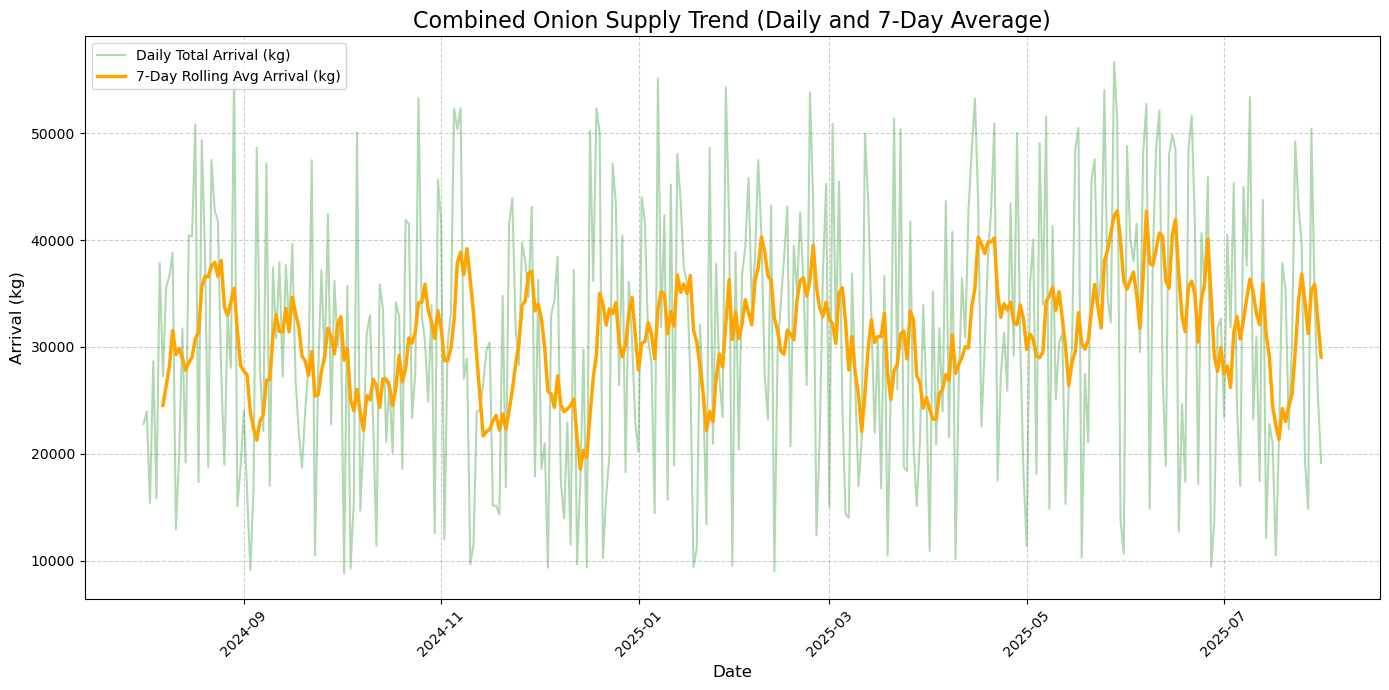

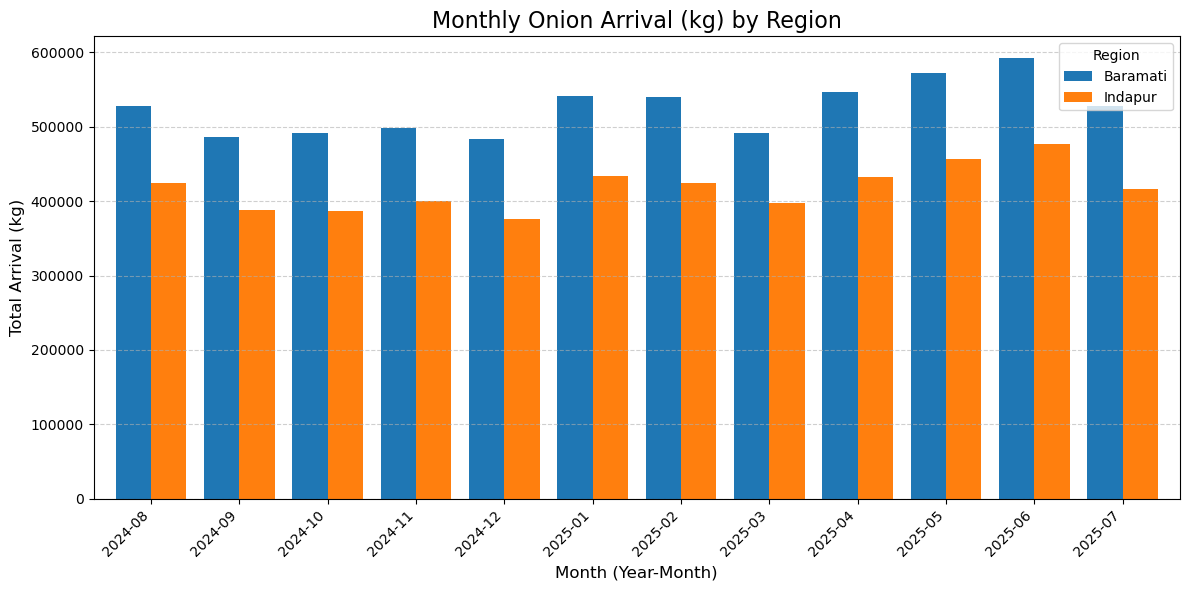

In [18]:
def main_analysis():
   
    df_onions = load_and_preprocess_data()

    if df_onions is not None:
        perform_statistical_analysis(df_onions)
        visualize_trends(df_onions)
        visualize_monthly_arrivals(df_onions)
        predict_next_4_days_demand(df_onions)
        suggest_supply_increase(df_onions)

if __name__ == '__main__':
    main_analysis()